# 1. Investigate Dataset

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
import keras

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.13.0
2.13.1


## 1.1. Load the dataset

In [2]:
df_diabetes = pd.read_csv("diabetes.csv")

# Exact the feature names and label names
feature_names = df_diabetes.drop(["Outcome"], axis = 1)
print("feature names: ", feature_names.columns)

label_names= df_diabetes["Outcome"].copy()
print("label names:\n", label_names.value_counts())

# Print infomation about the data
display(df_diabetes.head())
df_diabetes.info()
display(df_diabetes.describe().T)

feature names:  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')
label names:
 0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


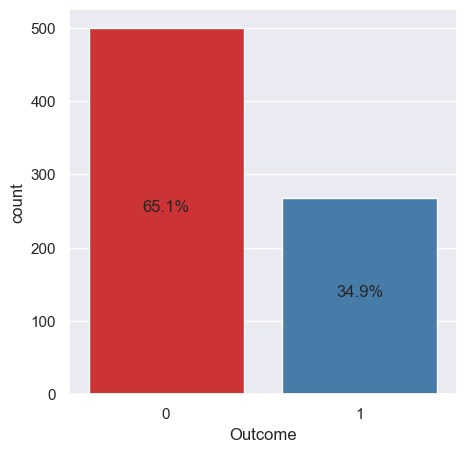

In [3]:
# Graphically show the proportions of the labels in the whole dataset
plt.figure(figsize=(5, 5))
total = float(len(df_diabetes))
ax = sns.countplot(x="Outcome", data=df_diabetes, palette="Set1")

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2
    ax.annotate(percentage, (x, y), ha="center")



## 1.2 Visualise the dataset

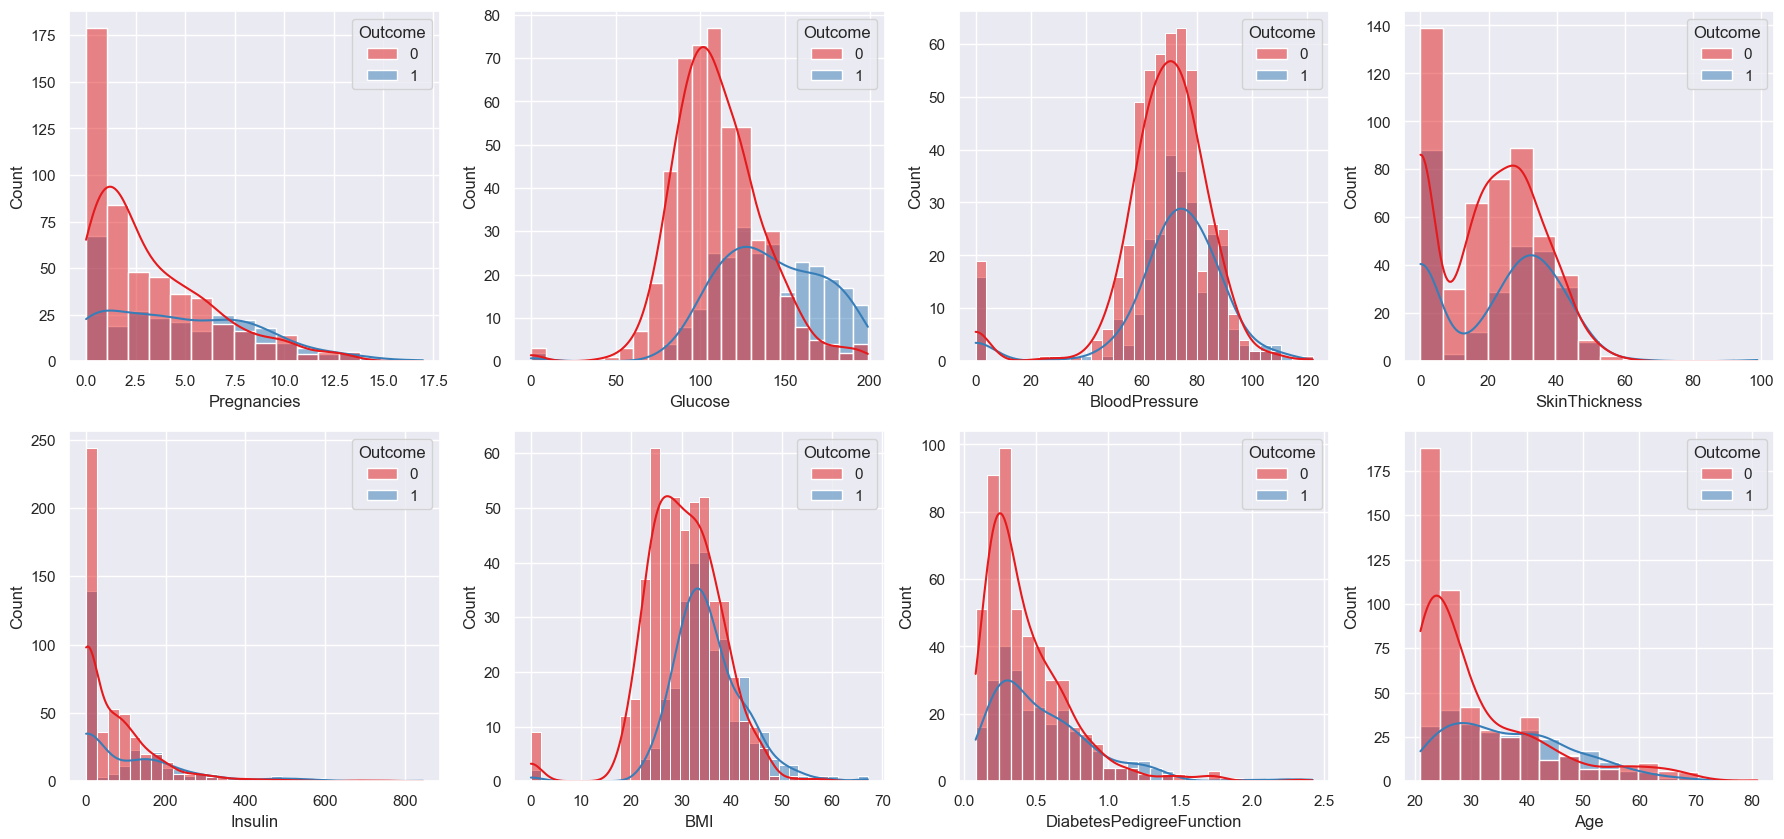

In [4]:
# Your code here
def histogram(features, Nrows, Ncols):
    fig, axes = plt.subplots(Nrows, Ncols, figsize=(22, 10))

    for row in range(Nrows):
        for col in range(Ncols):
            feature = features[row*Ncols + col]
            sns.histplot(ax=axes[row, col], x=feature, data=df_diabetes, kde=True, palette='Set1', hue='Outcome', edgecolor=None)

histogram(list(feature_names[0:8]),2,4)


## 1.3 Data-preprocessing

In [5]:
duplicate = df_diabetes[df_diabetes.duplicated()]
print("Duplicate Rows :",duplicate)

Duplicate Rows : Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []


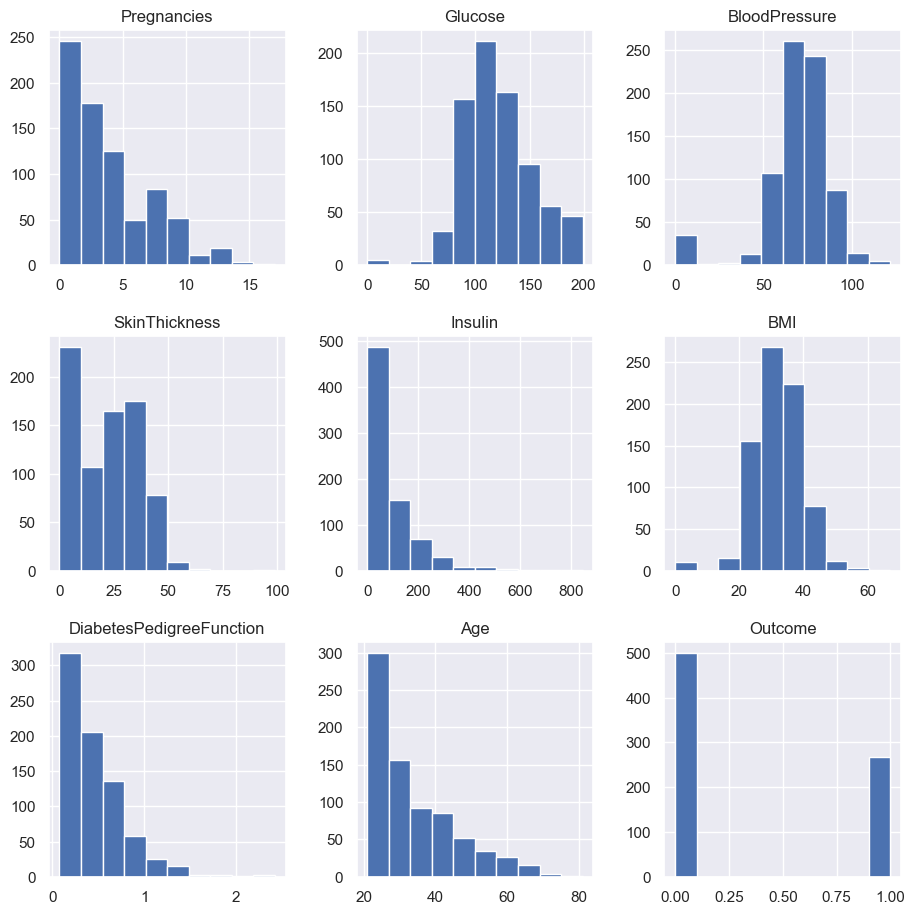

In [6]:
df_diabetes.hist(figsize=(11,11));

### 1.3.1. Missing value

In [7]:
df_diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
print((df_diabetes == 0).sum())

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


In [9]:
df_diabetes[['Pregnancies', 'Glucose','BloodPressure','SkinThickness',
      'Insulin','BMI']] = df_diabetes[['Pregnancies', 'Glucose','BloodPressure','SkinThickness',
                                       'Insulin','BMI']].replace(0,np.NaN)

In [10]:
df_diabetes.isnull().sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [11]:
#Creating a copy of data
df_diabetes_copy = df_diabetes.copy(deep=True)

In [12]:
for i in df_diabetes_copy.columns[df_diabetes_copy.isnull().any(axis=0)]:     
    df_diabetes_copy[i] = df_diabetes_copy.groupby(["Outcome"])[i].transform(lambda x: x.fillna(x.mean()))

### 1.3.2. Outlier data

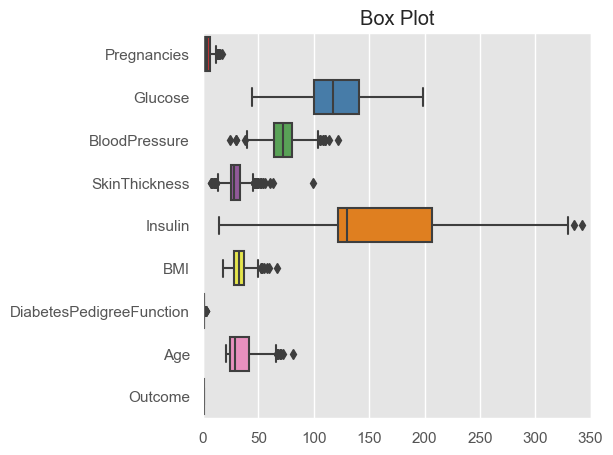

In [13]:
plt.style.use('ggplot') 

f, ax = plt.subplots(figsize=(5, 5))
ax.set(xlim=(-.05, 350))
plt.title("Box Plot")
ax = sns.boxplot(data = df_diabetes_copy, 
  orient = 'h', 
  palette = 'Set1')

In [14]:
Q1  = pd.DataFrame()
Q3  =   pd.DataFrame()
IQR =  pd.DataFrame()
UpperLimit =  pd.DataFrame()
LowerLimit =  pd.DataFrame()
Outlier_UpperLimit =  pd.DataFrame(index=[1,2,3,4])
Outlier_LowerLimit =  pd.DataFrame(index=[1,2,3,4])

columns = df_diabetes_copy.columns[0:-1]

for i in columns:
    Q1[i] = [df_diabetes_copy[i].quantile(0.25)]
    Q3[i]=  [df_diabetes_copy[i].quantile(0.75)]
    IQR[i] = [Q3[i][0]-Q1[i][0]]
    UpperLimit[i] = [Q3[i][0]+1.5*IQR[i][0]]
    LowerLimit[i] = [Q1[i][0]-1.5*IQR[i][0]]

In [15]:
df = pd.concat([Q1,Q3,IQR,UpperLimit,LowerLimit])
df.index = ["Q1","Q3","IQR","UpperLimit","LowerLimit"]
dft = df.T
dft

,Q1,Q3,IQR,UpperLimit,LowerLimit
Pregnancies,2.00000,6.000000,4.000000,12.000000,-4.000000
Glucose,99.75000,141.000000,41.250000,202.875000,37.875000
BloodPressure,64.00000,80.000000,16.000000,104.000000,40.000000
SkinThickness,25.00000,33.000000,8.000000,45.000000,13.000000
Insulin,121.50000,206.846154,85.346154,334.865385,-6.519231
BMI,27.50000,36.600000,9.100000,50.250000,13.850000
DiabetesPedigreeFunction,0.24375,0.626250,0.382500,1.200000,-0.330000
Age,24.00000,41.000000,17.000000,66.500000,-1.500000


In [16]:
columns_cap = ["Insulin","SkinThickness","DiabetesPedigreeFunction","Pregnancies","BloodPressure","BMI","Age"]

def Cap_Outliers(dff,column):
    for i in column:
        print('Working on column: {}'.format(i))
        dff[i] = np.where(dff[i]>dft["UpperLimit"][i],dft["UpperLimit"][i],
                            np.where(dff[i]<dft["LowerLimit"][i],dft["LowerLimit"][i],dff[i]))
    return dff

Cap_Outliers(df_diabetes_copy,columns_cap)

Working on column: Insulin
Working on column: SkinThickness
Working on column: DiabetesPedigreeFunction
Working on column: Pregnancies
Working on column: BloodPressure
Working on column: BMI
Working on column: Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000000,148.0,72.0,35.0,206.846154,33.6,0.627,50.0,1
1,1.000000,85.0,66.0,29.0,130.287879,26.6,0.351,31.0,0
2,8.000000,183.0,64.0,33.0,206.846154,23.3,0.672,32.0,1
3,1.000000,89.0,66.0,23.0,94.000000,28.1,0.167,21.0,0
4,5.669565,137.0,40.0,35.0,168.000000,43.1,1.200,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.000000,101.0,76.0,45.0,180.000000,32.9,0.171,63.0,0
764,2.000000,122.0,70.0,27.0,130.287879,36.8,0.340,27.0,0
765,5.000000,121.0,72.0,23.0,112.000000,26.2,0.245,30.0,0
766,1.000000,126.0,60.0,33.0,206.846154,30.1,0.349,47.0,1


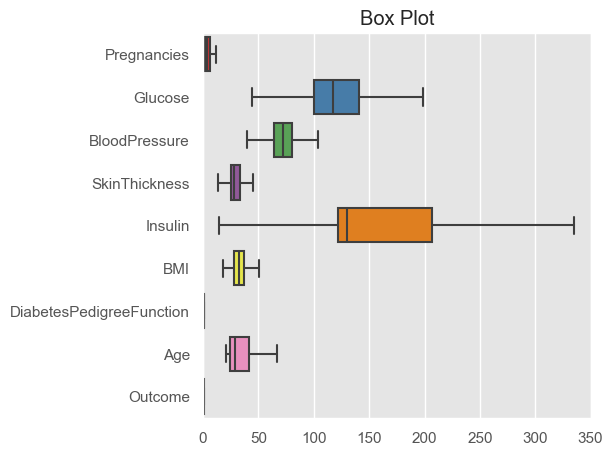

In [17]:
plt.style.use('ggplot') 

f, ax = plt.subplots(figsize=(5, 5))
ax.set(xlim=(-.05, 350))
plt.title("Box Plot")
ax = sns.boxplot(data = df_diabetes_copy, 
  orient = 'h', 
  palette = 'Set1')

## 1.4 Ranking the features

In [18]:
# Convert label column to numbers
corr = df_diabetes.corr()["Outcome"].sort_values(ascending=False)
print(corr)

Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
Pregnancies                 0.268218
SkinThickness               0.259491
Age                         0.238356
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64


## 1.5 Splitting the dataset 

In [19]:
df_diabetes_copy.shape

(768, 9)

In [20]:
# Your code here
from sklearn.model_selection import train_test_split

X = df_diabetes_copy.drop(columns="Outcome")
y = df_diabetes_copy["Outcome"]

X,X_test,y,y_test = train_test_split(X,y,test_size=0.25,random_state=42, stratify=y)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y)
print(f'Shapes of training, test, validation sets are {[X_train.shape,y_train.shape,X_test.shape,y_test.shape, X_val.shape,y_val.shape]}')
print("Distribution:", np.mean(y_train),np.mean(y_test), np.mean(y_val))

Shapes of training, test, validation sets are [(432, 8), (432,), (192, 8), (192,), (144, 8), (144,)]
Distribution: 0.34953703703703703 0.3489583333333333 0.3472222222222222


In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X = scaler.transform(X)


# 2. Implementing Multi-layer Perceptron Model

## 2.1. Baseline Multi-layer Perceptron Model

In [22]:
def plot_history(history,y=1):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history['accuracy'])
    plt.plot(np.arange(0,n),history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history['val_accuracy'],'r') 
    plt.plot(np.arange(0,n)+0.5,history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, y)  
    plt.show() 

In [23]:
X_train, X_test, X_val, X = map(torch.tensor, (X_train, X_test, X_val, X))
y_train, y_test, y_val, y = map(torch.tensor, (y_train.values.reshape(-1,1), y_test.values.reshape(-1,1), y_val.values.reshape(-1,1),  y.values.reshape(-1,1)))

X_train, X_test, X_val, X = X_train.float(), X_test.float(), X_val.float(), X.float()
y_train, y_test, y_val, y = y_train.float(), y_test.float(), y_val.float(), y.float()

In [24]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cpu


In [25]:
class dds(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)
    
trainset = dds(X_train,y_train)
valset = dds(X_val,y_val)

epoch= 1/100, accuracyTrain= 0.5185185185185185, accuracyVal= 0.6597222222222222, train_loss= 0.6757234145294536, validation_loss= 0.6528041561444601
epoch= 2/100, accuracyTrain= 0.7268518518518519, accuracyVal= 0.8125, train_loss= 0.6347600397738543, validation_loss= 0.610188380877177


epoch= 3/100, accuracyTrain= 0.8078703703703703, accuracyVal= 0.8263888888888888, train_loss= 0.5935717739842155, validation_loss= 0.5649879336357116
epoch= 4/100, accuracyTrain= 0.8217592592592593, accuracyVal= 0.8263888888888888, train_loss= 0.5492724173448302, validation_loss= 0.52187553246816
epoch= 5/100, accuracyTrain= 0.8287037037037037, accuracyVal= 0.8333333333333334, train_loss= 0.5073612440716136, validation_loss= 0.4840980529785156
epoch= 6/100, accuracyTrain= 0.8379629629629629, accuracyVal= 0.8333333333333334, train_loss= 0.477631652219729, validation_loss= 0.4522839923699697
epoch= 7/100, accuracyTrain= 0.8495370370370371, accuracyVal= 0.8333333333333334, train_loss= 0.46308797801082785, validation_loss= 0.4276714781920115
epoch= 8/100, accuracyTrain= 0.8495370370370371, accuracyVal= 0.8333333333333334, train_loss= 0.43711416829716077, validation_loss= 0.4102770884831746
epoch= 9/100, accuracyTrain= 0.8472222222222222, accuracyVal= 0.8333333333333334, train_loss= 0.42464

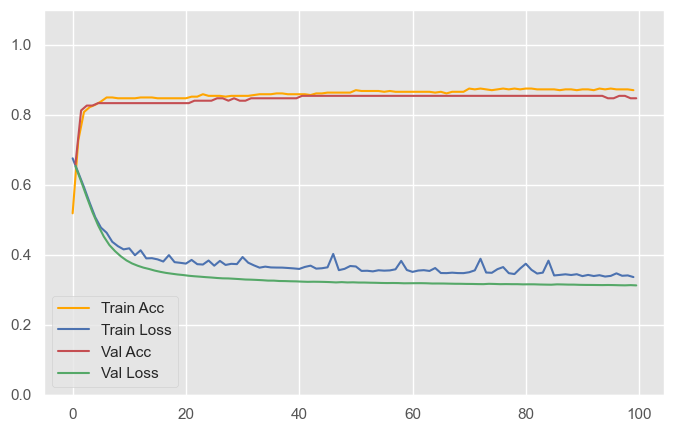

In [26]:
class MLP(nn.Module):
    def __init__(self, n_neurons=8):
        super().__init__()
        self.layer = nn.Linear(8, n_neurons)
        self.act = nn.ReLU()
        self.output = nn.Linear(n_neurons, 1)
        self.prob = nn.Sigmoid()
            
    def forward(self, x):
        x = self.act(self.layer(x))
        x = self.prob(self.output(x))
        return x
    
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


#batch wise training loop
def train(trainset, valset, epochs = 100, batch_size = 10, n_neurons = 8):
    model = MLP(n_neurons)
    loss_fn   = nn.BCELoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)
    train_losses = []
    val_losses = []

    history = {
        'accuracy': [],
        'loss': [],
        'val_accuracy': [],
        'val_loss': []
    }

    for epoch in range(epochs):  #epochs loop

        Y_train_epoch=np.array([]).reshape(0,1)
        Yhat_train_epoch=np.array([]).reshape(0,1)
        train_losses_epoch=np.array([])

        for X_train, Y_train in train_loader:        #batch wise  training on train set
            model.train()
            X_train = X_train.to(device)
            Y_train = Y_train.to(device)  
            y_hat = model(X_train)               
            loss = loss_fn(y_hat, Y_train)       
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            Y_train_epoch=np.vstack((Y_train_epoch,Y_train.detach().cpu().numpy()))
            Yhat_train_epoch=np.vstack((Yhat_train_epoch,y_hat.detach().cpu().numpy()))   
            train_losses_epoch=np.append(train_losses_epoch,loss.item())     
            
        
        train_losses.append(train_losses_epoch.mean()) 
        preidctions=(Yhat_train_epoch>=0.5) 
        acTrain=accuracy_score(Y_train_epoch, preidctions)


        Y_val_epoch=np.array([]).reshape(0,1)
        Yhat_val_epoch=np.array([]).reshape(0,1)
        val_losses_epoch=np.array([])
        for X_val, Y_val in val_loader: 
            model.eval()
            
            X_val = X_val.to(device)
            Y_val = Y_val.to(device)
            
            with torch.no_grad():            
                y_hat_val = model(X_val)           
                loss = loss_fn(y_hat_val, Y_val)
            
            Y_val_epoch=np.vstack((Y_val_epoch,Y_val.detach().cpu().numpy()))
            Yhat_val_epoch=np.vstack((Yhat_val_epoch,y_hat_val.detach().cpu().numpy()))   
            val_losses_epoch=np.append(val_losses_epoch,loss.item())     
                

        #computing metrics for current epoch
        val_losses.append(val_losses_epoch.mean()) 
        preidctions=(Yhat_val_epoch>=0.5) 
        acVal=accuracy_score(Y_val_epoch, preidctions)


        print(f"epoch= {epoch+1}/{epochs}, accuracyTrain= {acTrain}, accuracyVal= {acVal}, train_loss= {train_losses[epoch]}, validation_loss= {val_losses[epoch]}")
        history['accuracy'].append(acTrain)
        history['loss'].append(train_losses[epoch])
        history['val_accuracy'].append(acVal)
        history['val_loss'].append(val_losses[epoch])
        
    return model, history

model, history= train(trainset, valset)
print("The best validation accurancy: ",np.max(history['val_accuracy']))
plot_history(history,1.1)

## 3. Optimisation of multi-layer perceptron model with Grid Search

In [27]:
# create model with skorch
model = NeuralNetClassifier(
    MLP,
    criterion=nn.BCELoss,
    optimizer=optim.Adam,
    verbose=False
)

param_grid = {
    'batch_size': [60, 80, 100],
    'max_epochs': [100, 200],
    'module__n_neurons': [8, 16, 32, 64, 128]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.831597 using {'batch_size': 80, 'max_epochs': 100, 'module__n_neurons': 128}
0.805556 (0.010702) with: {'batch_size': 60, 'max_epochs': 100, 'module__n_neurons': 8}
0.815972 (0.004910) with: {'batch_size': 60, 'max_epochs': 100, 'module__n_neurons': 16}
0.809028 (0.006496) with: {'batch_size': 60, 'max_epochs': 100, 'module__n_neurons': 32}
0.817708 (0.004253) with: {'batch_size': 60, 'max_epochs': 100, 'module__n_neurons': 64}
0.817708 (0.019488) with: {'batch_size': 60, 'max_epochs': 100, 'module__n_neurons': 128}
0.815972 (0.020097) with: {'batch_size': 60, 'max_epochs': 200, 'module__n_neurons': 8}
0.815972 (0.024181) with: {'batch_size': 60, 'max_epochs': 200, 'module__n_neurons': 16}
0.802083 (0.004253) with: {'batch_size': 60, 'max_epochs': 200, 'module__n_neurons': 32}
0.805556 (0.013670) with: {'batch_size': 60, 'max_epochs': 200, 'module__n_neurons': 64}
0.814236 (0.004910) with: {'batch_size': 60, 'max_epochs': 200, 'module__n_neurons': 128}
0.821181 (0.004910) with:

# 4. Selection of the best and reporting of final results

epoch= 1/100, accuracyTrain= 0.5023148148148148, accuracyVal= 0.625, train_loss= 0.7019350230693817, validation_loss= 0.6699748635292053
epoch= 2/100, accuracyTrain= 0.7175925925925926, accuracyVal= 0.7916666666666666, train_loss= 0.6541308065255483, validation_loss= 0.6263381838798523
epoch= 3/100, accuracyTrain= 0.7546296296296297, accuracyVal= 0.7986111111111112, train_loss= 0.6116323471069336, validation_loss= 0.5891431868076324
epoch= 4/100, accuracyTrain= 0.7800925925925926, accuracyVal= 0.8263888888888888, train_loss= 0.5757560332616171, validation_loss= 0.556829422712326
epoch= 5/100, accuracyTrain= 0.7986111111111112, accuracyVal= 0.8125, train_loss= 0.5522773166497549, validation_loss= 0.5289962887763977
epoch= 6/100, accuracyTrain= 0.8009259259259259, accuracyVal= 0.8125, train_loss= 0.5170361697673798, validation_loss= 0.5054982304573059
epoch= 7/100, accuracyTrain= 0.8125, accuracyVal= 0.8125, train_loss= 0.4946072002251943, validation_loss= 0.48561273515224457
epoch= 8/10

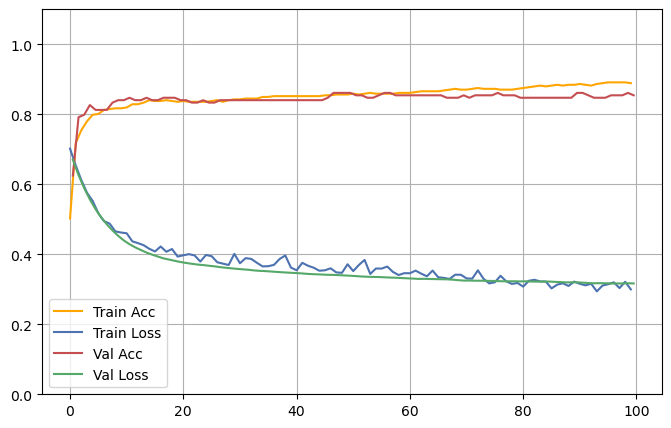

In [31]:
model, history = train(trainset, valset, epochs = 100, batch_size = 80, n_neurons = 128)
print("The best validation accurancy: ",np.max(history['val_accuracy']))
plot_history(history,1.1)

In [32]:
y_pred = model(X_test)
y_pred_binary = (y_pred >= 0.5).float()
accuracy = accuracy_score(y_pred_binary, y_test)
print(f"Accuracy {accuracy}")

Accuracy 0.8229166666666666


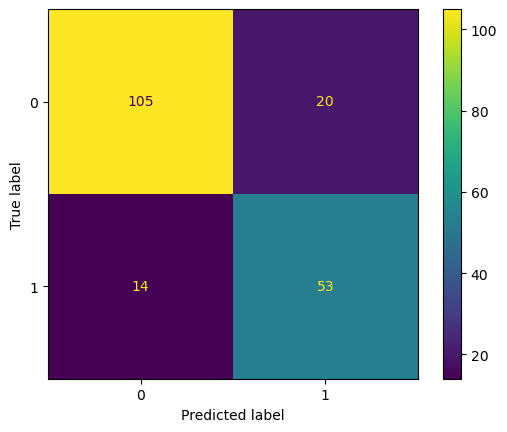

In [33]:
from sklearn import metrics
plt.rcParams.update(plt.rcParamsDefault)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_binary)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()